<div><img src="logo.jpg", width=150, ALIGN="left", border=20></div>
<center>
<h1>Time Series Challenge Starting Kit</h1>
<br>This code was tested with <br>
Python Anaconda Python 3.7, June 8, 2020
</center>
<p><br>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The UPSud, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
model_dir = 'sample_code_submission/'  # Change the model to a better of your own design!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
data_dir = 'sample_data'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
from os.path import join
import numpy as np

## Locating the sample data
Data are formatted in this example like on the Codalab server (where your code submission is evaluated) in two subdirectories "training" and "evaluation". 

In [2]:
!ls $data_dir*/*

sample_data/metadata                sample_data/sample_data_license.txt

sample_data/evaluation:
evaluation0.csv evaluation1.csv

sample_data/training:
training0.csv training1.csv training2.csv


## Understanding the DataManager object
The DataManager class allows you to painlessly load and explaore your data.

### Load training data and evaluation data

In [3]:
from data_manager import DataManager 

Din = DataManager(datatype="input", verbose=True) 
Din.loadData(data_dir)

DataManager :: Version = 1
DataManager :: ========= Reading training data from sample_data
DataManager :: ========= Load data from files:
['sample_data/training/training0.csv', 'sample_data/training/training1.csv', 'sample_data/training/training2.csv']
['sample_data/evaluation/evaluation0.csv', 'sample_data/evaluation/evaluation1.csv']
[+] Success, loaded 38 samples in  0.01 sec


True

Din contains several attributes: 
    - X: ndarray representing an array of feature vectors (frames).
    - t: ndarray representing the time index (a positive integer).
This command just loaded a single sequence of 38 time steps. Frames have 5 dimensions in this example.

In [4]:
print(type(Din.X), Din.X.shape)
print(type(Din.t), Din.t.shape)

<class 'numpy.ndarray'> (38, 5)
<class 'numpy.ndarray'> (38,)


Other data members include:
    - t0: the index of the first evaluation frame.
    - ycol0: the index of the first variable in a frame this must be  predicted (only the last few variables must  be predicted).
    - stride: steps made until the next prediction is requested.
    - horizon: number of frames in the future that must be predicted.
You can inspect the data with a simple print statement:

In [5]:
print(Din)

DataManager :: ========= Info =========
Version = 1
Data type = input
Stride = 1
Horizon = 7
Num training samples = 24
Num evaluation samples = 14
Num input variables = 5
Input variables = ('X1', 'X2', 'X3', 'Y1', 'Y2')
Num output variables = 2
Output variables = ('Y1', 'Y2')



## Visualizing data
We provide a simple method to show a heat map of your data.

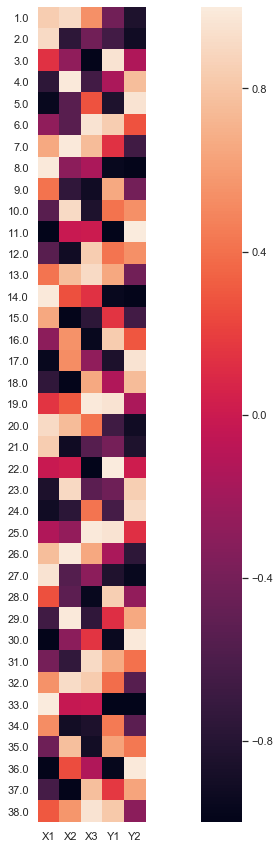

In [6]:
Din.show(transpose=False) 

## Making predictions
You can also use the class DataManager to store your predictions:

In [7]:
Dout = DataManager(datatype="output", verbose=True)
Dout.col_names = Din.col_names[Din.ycol0:]
Dout.horizon = Din.horizon
Dout.stride = Din.horizon 

DataManager :: Version = 1


Then instanciate your Model (recall, this is what you need to modify):

In [8]:
from model import Model
M = Model()
?? Model

To make predictions, loop over data samples:

In [9]:
X, tx = Din.getHistoricalData()
ty = Din.t[Din.now-Din.stride:Din.now-Din.stride+Din.horizon] 
while ty.shape[0]!=0:
    M.train(X, tx) 
    Y = M.predict(X, num_predicted_frames=Din.horizon, ycol0=Din.ycol0)
    Y = Y[:len(ty),:] # Clip predictions
    Dout.appendData(Y, ty) 
    X, tx = Din.getHistoricalData()
    ty = Din.t[Din.now-Din.stride:Din.now-Din.stride+Din.horizon]  

DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 7 frame(s)
DataManager :: ========= Appending 6 frame(s)
DataManager :: ========= Appending 5 frame(s)
DataManager :: ========= Appending 4 frame(s)
DataManager :: ========= Appending 3 frame(s)
DataManager :: ========= Appending 2 frame(s)
DataManager :: ========= Appending 1 frame(s)


Notice that when we reach the end of the evaluation data, the data manager knows to reduce the horizon to the number of ground truth values known in the future. You can now view your predictions (the persistence model is provided as example):

In [10]:
Dout

DataManager :
	<method-wrapper '__repr__' of numpy.ndarray object at 0x1a1f587d50>
	<method-wrapper '__repr__' of numpy.ndarray object at 0x11c973bc0>

DataManager :: ========= Info =========
Version = 1
Data type = output
Stride = 7
Horizon = 7
Num training samples = 0
Num evaluation samples = 77
Num input variables = 2
Input variables = ('Y1', 'Y2')
Num output variables = 2
Output variables = ('Y1', 'Y2')



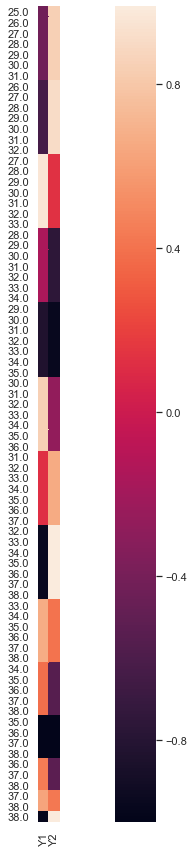

In [11]:
print(Dout)
Dout.show(transpose=False)

## Computing performance
Prediction accuracy is computed using the mean square error (MSE). You can run the scoring program that evaluates your predictions.

In [12]:
from metric import scoring_function
# Rewind the data managers
Din.resetTime() 
Dout.resetTime()
max_steps = Din.t.shape[0]-Din.t0
score = np.zeros(max_steps)
for step_num in range(max_steps): 
    Xsol, tsol = Din.getFutureOutcome()
    # Get next predictions for the given horizon
    Xpred, tpred = Dout.getPredictions() 
    score[step_num] = scoring_function(Xsol, Xpred)
    print("======= Step {}: ={:0.12f} =======".format(step_num, score[step_num]) )       
prediction_score = np.mean(score)
print("*** prediction_score = {:0.12f} ***".format(prediction_score))

======= Step 0: =0.963250000000 =======
======= Step 1: =1.148292857143 =======
======= Step 2: =1.142950000000 =======
======= Step 3: =0.757057142857 =======
======= Step 4: =1.356564285714 =======
======= Step 5: =1.087742857143 =======
======= Step 6: =0.646321428571 =======
======= Step 7: =1.525471428571 =======
======= Step 8: =0.793916666667 =======
======= Step 9: =0.695400000000 =======
======= Step 10: =2.065462500000 =======
======= Step 11: =0.989600000000 =======
======= Step 12: =0.206175000000 =======
======= Step 13: =2.434100000000 =======
*** prediction_score = 1.129450297619 ***


# Prepare your Submission

## Unit testing
It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code/</code> directory, then run this test to make sure everything works fine. 

In [13]:
!python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /Users/isabelleguyon/Downloads/starting_kit_sncf/sample_data
Using output_dir: /Users/isabelleguyon/Downloads/starting_kit_sncf/sample_result_submission
Using program_dir: /Users/isabelleguyon/Downloads/starting_kit_sncf/ingestion_program
Using submission_dir: /Users/isabelleguyon/Downloads/starting_kit_sncf/sample_code_submission

========== Ingestion program version 1 ==========

****************************************************
******** Processing spatio-temporal dataset ********
****************************************************
========= Reading and converting data ==========
DataManager :: Version = 1
DataManager :: ========= Reading training data from /Users/isabelleguyon/Downloads/starting_kit_sncf/sample_data
DataManager :: ========= Load data from files:
['/Users/isabelleguyon/Downloads/starting_kit_sncf/sample_data/training/training0.csv', '/Users/isabelleguyon/Downloads/starting_kit_sncf/sample_data/training/training1.csv', '/Users/isabelleguyon/Downlo

In [14]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

========= Reading solution data ==========
DataManager :: Version = 1
DataManager :: ========= Reading training data from sample_data
/Users/isabelleguyon/Downloads/starting_kit_sncf/scoring_program/data_manager.py:144: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(open(join(data_dir, 'metadata'), 'r'))
DataManager :: ========= Load data from files:
['sample_data/training/training0.csv', 'sample_data/training/training1.csv', 'sample_data/training/training2.csv']
['sample_data/evaluation/evaluation0.csv', 'sample_data/evaluation/evaluation1.csv']
[+] Success, loaded 38 samples in  0.00 sec
DataManager :: ========= Info =========
Version = 1
Data type = input
Stride = 1
Horizon = 7
Num training samples = 24
Num evaluation samples = 14
Num input variables = 5
Input variables = ('X1', 'X2', 'X3', 'Y1', 'Y2')
Num output variables = 2
Output variables = (

## Making your Submission

Zip your code, NOT including the <span style="color:red">sample_code/</span> directory, but including metadata.

In [15]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
print("Submit file:\n" + sample_code_submission + "\n")
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_result_submission, result_dir)
print("... or for debug purposes, submit file:\n" + sample_result_submission + "\n")

Submit file:
../sample_code_submission_20-06-08-14-18.zip

... or for debug purposes, submit file:
../sample_result_submission_20-06-08-14-18.zip

